# TensorFlood

## OCEANIC NINO INDEX (ONI)

The Oceanic Niño Index (ONI) is NOAA's primary indicator for monitoring El Niño and La Niña, which are opposite phases of the climate pattern called the El Niño-Southern Oscillation, or “ENSO” for short. NOAA considers El Niño conditions to be present when the Oceanic Niño Index is +0.5 or higher, indicating the east-central tropical Pacific is significanty warmer than usual.  La Niña conditions exist when the Oceanic Niño Index is -0.5 or lower, indicating the region is cooler than usual. 

The ONI tracks the running 3-month average sea surface temperatures in the east-central tropical Pacific between 120°-170°W. Scientists call the area the Niño 3.4 region. 

To calculate the ONI, scientists from NOAA's Climate Prediction Center calculate the average sea surface temperature in the Niño 3.4 region for each month, and then they average it with values from the previous and following months. This running three-month average is compared to a 30-year average. The observed difference from the average temperature in that region—whether warmer or cooler—is the ONI value for that 3-month "season." 

Source: https://www.climate.gov/news-features/understanding-climate/climate-variability-oceanic-ni%C3%B1o-index

#### Figure 1: Location of Nino3.4
Source: https://www.climate.gov/news-features/understanding-climate/climate-variability-oceanic-ni%C3%B1o-index

<img src="./Images/Map-Nino.jpeg">

#### Tabla 1. Threshold to identify weather 'El Niño' 

<img src="./Images/umbrales_nino.jpeg">

#### Source: NOAA

1982 - 1983 - Fallecidos 512 - 8500 Enfermedades, Heridos 1304
1997 - 1998 - Fallecidos 366 - Heridos 1053 - Centros de salud 580 - centros educativos 2873
2016 - 2017

Land cover type is an important factor due to its influence on the precipitation water runoff for a decision what kind of crop is suitable for a given region. This choice can substantially affect the future impact of floods (e.g. corn is a crop which can negatively influence the area during the flash floods). The second problem is an expansion of crop to forest areas (deforestation). This process has also a negative impact on influence of upcoming flash flood.

Source:
Halounova L. & Holubec V. (2014). Assesment of flood with regards to Land Cover Changes. DOI: 0.1016/S2212-5671(14)01021-1

In [1]:
# !pip3 install meteomatics
# !pip3 install datetime

# for map visualization
# !pip3 install cartopy
# !pip3 install more-itertools

# Ubuntu
# !sudo apt-get install libproj-dev proj-data proj-bin  
# !sudo apt-get install libgeos-dev  
# !pip install cython  
# !pip install cartopy  

In [2]:
# For weather-data adqusicion
import meteomatics.api as api
import datetime as dt

# For managing data
import numpy as np
import pandas as pd

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline

# For machine learning
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

## Restricting our dataset

In [3]:
# Extract latitud and longitud from affected cities
peru = [
    {'name':'Tumbes', 'lat':-3.56694, 'long':-80.45153},
    {'name':'Chiclayo', 'lat': -6.77361, 'long': -79.84},
    {'name':'Piura', 'lat': -5.19449, 'long': -80.63282},
]

## Obtaining data

We are going to find if there is any relationship with our gather data and probability of a weather El Nino. We are goint to extract dates and level of threat, where higher means more.

- Dec 1982 - Jun 1983 - Level Threat 3
- Nov 1997 - Apr 1998 - Level Threat 3
- Dec 2002 - May 2003 - Level Threat 2
- Dec 2004 - May 2005 - Level Threat 1
- Dec 2006 - May 2007 - Level Threat 1
- Dec 2009 - May 2010 - Level Threat 2
- Dec 2016 - May 2017 - Level Threat 2

In [4]:
dates= [
    {'start_m':12, 'duration':7, 'end_m':6, 'start_y':1982, 'lvl_threat':3},
    {'start_m':11, 'duration':5, 'end_m':4, 'start_y':1997, 'lvl_threat':3},
    {'start_m':12, 'duration':6, 'end_m':5, 'start_y':2002, 'lvl_threat':2},
    {'start_m':12, 'duration':6, 'end_m':5, 'start_y':2004, 'lvl_threat':1},
    {'start_m':12, 'duration':6, 'end_m':5, 'start_y':2006, 'lvl_threat':1},
    {'start_m':12, 'duration':6, 'end_m':5, 'start_y':2009, 'lvl_threat':2},
    {'start_m':12, 'duration':6, 'end_m':5, 'start_y':2016, 'lvl_threat':2},
]

### Obtaining data from Meteomatics

In [5]:
# Credentials
username = 'tensorflood_naruse'
password = 'VsSO0Qzm32taN'

In [6]:
# Define a function that returns df of selected lat, lon and timeframes
def df_meteomatics(lat, lon, start_year, start_month, start_day, number_years, interval_months):
    lat_lon = [tuple((lat, lon))]
    d = dt.date(start_year, start_month, start_day)
    t = dt.time(0, 0)
    startdate = dt.datetime.combine(d, t)
    enddate=startdate + dt.timedelta(days=number_years*365)
    interval = dt.timedelta(days=interval_months*30)
    parameters = ['t_2m:C', 'precip_1h:mm', 'wind_speed_50m:ms', 'wind_dir_50m:d', 'relative_humidity_2m:p', 'global_rad:W']
    df = api.query_time_series(latlon_tuple_list=lat_lon, startdate=startdate, enddate=enddate, interval=interval, parameters=parameters, username=username, password=password)
    
    # Modifying the values of the multindex
    year = []
    month = []
    day = []
    for i in range(len(df.index.get_level_values(2).date)):
        year.append(df.index.get_level_values(2).date[i].year)
        month.append(df.index.get_level_values(2).date[i].month)
        day.append(df.index.get_level_values(2).date[i].day)
    df.insert(0, 'year', year)
    df.insert(1, 'month', month)
    df.insert(2, 'day', day)
    
    # Erase the multiindex
    df.reset_index(inplace=True)

    # Drop validdate
    df.drop(['validdate'], axis = 1, inplace=True)
    
    return df

- lat: latitude
- lon: longitude
- year: year
- month: month
- day: day
- t_2m:C: temperature above 2m in celsius
- precip_1h:mm: precipitation in 1h in milimeters
- wind_speed_50:ms: wind speed above 50m in meters/s
- relative_humidity_2m:p: relative humidity above 2m
- global_rad:W: global radiation in wats

### Obtaining data from NOAA

In [7]:
# Read data from NOAA dataset
df_oni = pd.read_csv('https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt', delimiter='\s+')

# Converting ANOM to categorical value
df_oni.loc[df_oni['ANOM'] <= -1.5, 'ONI'] = 'Freezing cold'
df_oni.loc[(df_oni['ANOM'] >= -1.5)&(df_oni['ANOM'] <= -1), 'ONI'] = 'Moderate cold'
df_oni.loc[(df_oni['ANOM'] >= -1)&(df_oni['ANOM'] <= -0.5), 'ONI'] = 'cold' 
df_oni.loc[(df_oni['ANOM'] >= -0.5)&(df_oni['ANOM'] <= 0.5), 'ONI'] = 'Normal' 
df_oni.loc[(df_oni['ANOM'] >= 0.5)&(df_oni['ANOM'] <= 1), 'ONI'] = 'Hot'   
df_oni.loc[(df_oni['ANOM'] >= 1)&(df_oni['ANOM'] <= 1.4), 'ONI'] = 'Moderate hot'
df_oni.loc[df_oni['ANOM']>1.4, 'ONI'] = 'Burning hot' 

- YR: represents year
- MON: represents month
- TOTAL: Prom Temperature of seas - 3 month average
- ClimAdjust: Temp of sea - 30 year average
- ANOM: ONI

## Obtaining soil data 1
source: Fritz, Steffen; See, Linda; Perger, Christoph; McCallum, Ian; Schill, Christian; Schepaschenko, Dmitry; Duerauer, Martina; Karner, Mathias; Dresel, Christopher; Laso-Bayas, Juan-Carlos; Lesiv, Myroslava; Moorthy, Inian; Salk, Carl F; Danylo, Olha; Sturn, Tobias; Albrecht, Franziska; You, Liangzhi; Kraxner, Florian; Obersteiner, Michael (2016): A global dataset of crowdsourced land cover and land use reference data (2011-2012). PANGAEA, https://doi.org/10.1594/PANGAEA.869680, In: Fritz, S et al. (2016): A global dataset of crowdsourced land cover and land use reference data (2011-2012). PANGAEA, https://doi.org/10.1594/PANGAEA.869682

In [8]:
df_soil_1 = pd.read_csv('./Data/GlobalCrowd.tab', sep='\t', header=None)
df_soil_1.columns = ['ID_Competition', 'ID_Pixel', 'ID_User', 'Lon', 'Lat', 
                     'HI_1', 'LC_1', 'Perc_1', 'HI_2', 'LCC_2', 'Perc_2', 
                     'HI_3', 'LCC_3','Per_3', 'Conf_HI', 'Conf_LC', 'Resolution',
                     'Code', 'Date/Time_data', 'Date/Time_Image', 'Size', 
                     'Conf_Aban', 'Conf']
df_soil_1.dropna(axis=1, how='all', inplace=True)

- ID_Competition: Competition ID, 1 = human impact, 2 = disagreement, 3 = wilderness, 4 = validation
- ID_Pixel: Unique Pixel ID
- ID_User: Unique User ID
- Lon: Longitude
- Lat: Latitude
- HI_1: Human impact 1
- LC1_1 : Land Cover 1, 1 = tree cover, 2 = shrub cover, 3 = herbaceus vegetation, 4 = cultivated and managed, 5 = mosaic, 6 = refularly floodes, 7 = urban, 8 = snow, 9 = barren, 10 = open water
- Perc_1 = Percentage 1
- Conf_HI: Confidence human impact, 0 = sure, 10 = quite sure, 20 = less sure, 30 = insure
- Conf_LC: Confidence Land Cover, 0 = sure, 10 = quite sure, 20 = less sure, 30 = insure
- Resolution: High resolution used
- Code: More than 3 Land Cover Classes present in pixel
- DATE/TIME_data: The date and time the entry was submitted
- DATE/TIME_Pix: The image date used, entered by volunteer
- Size: size of agricultural fields, 1 = very samll, 2 = small, 3 = medium, 4 = large
- Conf_Aban: Confidence of abandoment, 0 = sure, 10 = quite sure, 20 = less sure, 30 = insure
- Conf = ...

## Working with the datasets

Peru Limits
- Punta superior = [-0.428969, -75.411832]
- Punta inferior = [-18.528804, -70.295587]
- Punta izquierda = [-5.895779, -81.116966]
- Punta derecha = [-4.240466, -69.82373]

In [9]:
lim_lat = (df_soil_1['Lat'] >= -18.528804)&(df_soil_1['Lat'] <= -0.428969)
lim_lon = (df_soil_1['Lat'] >= -81.11696)&(df_soil_1['Lat'] <= -69.82373)
df_soil_1[lim_lat&lim_lon]

,ID_Competition,ID_Pixel,ID_User,Lon,Lat,HI_1,LC_1,Perc_1,HI_2,LCC_2,...,Per_3,Conf_HI,Conf_LC,Resolution,Code,Date/Time_data,Date/Time_Image,Size,Conf_Aban,Conf


- There is not available data

In [10]:
# Obtaining data from cities within 40 years

# j: index of city
def obtain_df_i(j):
    df_1 = df_meteomatics(peru[j]['lat'], peru[j]['long'], 1980, 1, 1, 40, 1)
    for i in range(len(dates)):
        df_1.loc[((df_1['month']>=dates[i]['start_m'])&(df_1['year']==dates[i]['start_y']))|((df_1['month']<=dates[i]['end_m'])&(df_1['year']==dates[i]['start_y']+1)), 'Target']=dates[i]['lvl_threat']
    return df_1

In [11]:
# City 0 with different time frames
df_0 = obtain_df_i(0)

# City 1 with different time frames
# df_1 = obtain_df_i(1)

# City 1 with different time frames
# df_2 = obtain_df_i(2)

2020-10-04 14:22:34| INFO |Calling URL: https://api.meteomatics.com/1980-01-01T00:00:00+00:00--2019-12-22T00:00:00+00:00:P30D/t_2m:C,precip_1h:mm,wind_speed_50m:ms,wind_dir_50m:d,relative_humidity_2m:p,global_rad:W/-3.56694,-80.45153/bin?connector=python_v2.1.0 (username = tensorflood_naruse)


In [12]:
# Defining a function to merge ANOM to df of Meteomatics
def df_merging(df, df_oni):
    df_1 = df.merge(df_oni, how='inner',left_on=['year', 'month'], right_on=['YR', 'MON'])
    df_1.drop(['YR', 'MON', 'TOTAL', 'ClimAdjust'], axis=1, inplace=True)
    return df_1

In [13]:
# Merging datasets
df_0_merged = df_merging(df_0, df_oni)
# df_1_merged = df_merging(df_1, df_oni)
# df_2_merged = df_merging(df_2, df_oni)

In [14]:
# Drop lat, lon, year, month, day and ONI since its not usable
def drop_function(df):
    try:
        df.drop(['lat', 'lon', 'year', 'month', 'day', 'ONI'], axis = 1, inplace=True)
        df = df.reindex(columns=['t_2m:C', 'precip_1h:mm', 'wind_speed_50m:ms', 'wind_dir_50m:d', 'relative_humidity_2m:p'
                                , 'global_rad:W', 'ANOM', 'Target'])
        
        return df
    except:
        pass

In [15]:
df_0_dropped = drop_function(df_0_merged)
# drop_function(df_1)
# drop_function(df_2)

## Imputing null values of Target

In [40]:
impute_zeros = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0).fit(df_0_dropped)
df_0_imputed = pd.DataFrame.from_records(
    data=impute_zeros.transform(
        X=df_0_dropped
    ),
    columns=df_0_dropped.columns
)

## Some visualization

In [41]:
df_0_imputed

,t_2m:C,precip_1h:mm,wind_speed_50m:ms,wind_dir_50m:d,relative_humidity_2m:p,global_rad:W,ANOM,Target
0,25.8,0.00,3.8,272.4,71.8,0.0,0.70,0.0
1,26.6,0.19,2.2,275.0,73.8,0.0,0.70,0.0
2,26.5,0.00,1.9,286.2,68.3,0.0,0.28,0.0
3,27.7,0.00,2.4,353.1,71.0,0.0,0.28,0.0
4,25.0,0.13,3.2,278.6,82.9,0.0,0.34,0.0
...,...,...,...,...,...,...,...,...
482,21.1,0.00,4.8,253.5,81.2,0.0,-0.01,0.0
483,19.9,0.00,3.8,252.4,86.3,0.0,-0.04,0.0
484,21.8,0.00,2.3,268.4,85.5,0.0,0.45,0.0
485,22.3,0.00,5.0,251.9,79.7,0.0,0.48,0.0


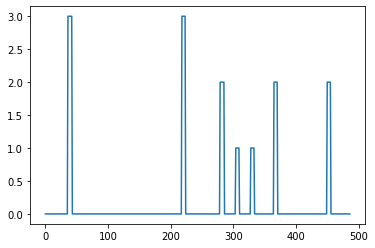

In [42]:
plt.plot(range(0, 487), df_0_imputed['Target'])

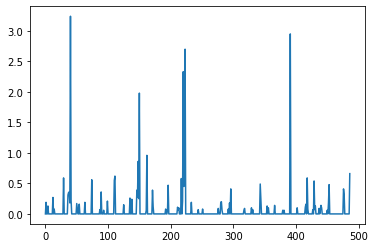

In [70]:
plt.plot(range(0, 487), df_0_imputed['precip_1h:mm'])

In [43]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Level of threat')
    plt.plot(predicted, color='blue',label='Predicted level of threat')
    plt.title('Level of threat')
    plt.xlabel('Time')
    plt.ylabel('Level of threat')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [44]:
# Split
# training_set = df_0_imputed[:350].iloc[:,:].values
# test_set = df_0_imputed[351:].iloc[:,:].values

training_set = df_0_imputed[:400]
test_set = df_0_imputed[400:]

In [51]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,3))
training_set_scaled = sc.fit_transform(training_set)

In [61]:
# Since LSTMs store long term memory state, we create a data structure with 10 timesteps and 1 output
# So for each element of training set, we have 10 previous training set elements 
X_train = []
y_train = []
for i in range(10,400):
    X_train.append(training_set_scaled[i-10:i,:])
    y_train.append(training_set_scaled[i,:])
X_train, y_train = np.array(X_train), np.array(y_train)

In [1]:
# Reshaping X_train for efficient modelling
# X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [2]:
# The LSTM architecture
# regressor = Sequential()
# First LSTM layer with Dropout regularisation
# regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
# regressor.add(Dropout(0.2))
# Second LSTM layer
# regressor.add(LSTM(units=50, return_sequences=True))
# regressor.add(Dropout(0.2))
# Third LSTM layer
# regressor.add(LSTM(units=50, return_sequences=True))
# regressor.add(Dropout(0.2))
# Fourth LSTM layer
# regressor.add(LSTM(units=50))
# regressor.add(Dropout(0.2))
# The output layer
# regressor.add(Dense(units=1))

# Compiling the RNN
# regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
# regressor.fit(X_train,y_train,epochs=50,batch_size=32)

In [ ]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
# dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
# inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
# inputs = inputs.reshape(-1,1)
# inputs  = sc.transform(inputs)

In [ ]:
# Preparing X_test and predicting the prices
# X_test = []
# for i in range(60,311):
#    X_test.append(inputs[i-60:i,0])
# X_test = np.array(X_test)
# X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
# predicted_stock_price = regressor.predict(X_test)
# predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
# Visualizing the results for LSTM
# plot_predictions(test_set,predicted_stock_price)